# 01 · Data & EDA (очистка, анализ, сплиты)

**Цель.** Понять структуру данных, очистить шум/дубликаты/кодировки, проверить баланс классов и подготовить корректные train/valid/test сплиты без утечек.

**Что делаем**

- Загрузка сырых выгрузок + проверка кодировок.
    
- Дедупликация, чистка HTML/смайлов/шаблонного спама, нормализация пробелов.
    
- Аналитика классов: частоты, редкие/слипающиеся классы, пересечения тематики.
    
- Разметка/валидация: сверка меток, золотые примеры для sanity.
    
- Разбиение на сплиты (стратифицированно; группируем по item_id/phone/email для избежания утечек).
    
- Контроль качества: длина текстов, top tokens/phrases, потенциальные источники bias.
    

**Выходы**

- `data/train.csv`, `data/valid.csv`, `data/test.csv`
    
- Мини-отчет EDA (короткий Markdown с ключевыми графиками и наблюдениями)
    

**Риски/наблюдения**

- Долгие объявления (лонгриды) -> нужны меры на инференсе (см. ноутбук 05: chunk-aware).
    
- Пограничные категории (смартфоны vs. электроника; авто vs. автоаксессуары) -> помечаем для R&D.
    
- Кросс-постинг одного объявления -> групповые сплиты обязательны.
    

## 1. Обзор датасета (EDA): структура, качество, базовая статистика
Цель: понять схему данных, пропуски/дубликаты, распределения ключевых полей.


In [1]:
# Импорты и базовые настройки
import re, math, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 200)
RANDOM_STATE = 42

DATA_PATH = Path("../data/synthetic_ru_private_ads_50cats_10000_v2.csv")
assert DATA_PATH.exists(), f"Файл не найден: {DATA_PATH}"


In [2]:
# Загрузка данных (dtypes + parse_dates)
dtypes = {
    "id": "string",
    "title": "string",
    "description": "string",
    "category": "string",
    "condition": "string",
    "city": "string",
    "price": "float64",
    "currency": "string",
    "source": "string",
}
df = pd.read_csv(DATA_PATH, dtype=dtypes, parse_dates=["posted_at"])
print(df.shape)
df.head(3)


(10000, 10)


,id,title,description,category,condition,city,price,currency,posted_at,source
0,fd6c2aae-a67c-4d0a-8aca-468114fdd2bc,Продаю автоаксессуары — Санкт-Петербург,Покажу сегодня. Без дтп. Документы в наличии. Возможен торг. Состояние отличное. Город: Тюмень.,Автоаксессуары,удовлетворительное,Санкт-Петербург,62854.0,RUB,2025-03-27 17:16:19,synthetic_ru_private_ads_v2
1,1de380f2-85b5-44c9-96d5-a923c29737b5,Продаю автоаксессуары — Казань,Город: Воронеж. Договорная. Обслуживание у дилера. Без посредников. Звоните / пишите. Доставка по городу. Бережная эксплуатация.,Автоаксессуары,на запчасти,Уфа,83030.0,RUB,2025-04-24 16:42:19,synthetic_ru_private_ads_v2
2,1646a31d-943e-4510-a3f5-57417f3a23db,В продаже автоаксессуары — Нижний Новгород,Гаражное хранение. Город: Новосибирск. Покажу сегодня. Разумный торг.,Автоаксессуары,новое,Хабаровск,70628.0,RUB,2025-08-02 18:05:19,synthetic_ru_private_ads_v2


In [3]:
# Схема, пропуски, дубликаты
display(pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "na_count": df.isna().sum(),
    "unique": df.nunique(dropna=True)
}).sort_values("na_count", ascending=False))

print("\nДубликаты по всей строке:", df.duplicated().sum())
if "id" in df.columns:
    print("Дубликаты по id:", df["id"].duplicated().sum())


,dtype,na_count,unique
id,string,0,10000
title,string,0,5552
description,string,0,9978
category,string,0,50
condition,string,0,7
city,string,0,25
price,float64,0,9871
currency,string,0,1
posted_at,datetime64[ns],0,9910
source,string,0,1



Дубликаты по всей строке: 0
Дубликаты по id: 0


In [4]:
# Частоты: category / city / currency / condition
for col in ["category", "city", "currency", "condition", "source"]:
    if col in df.columns:
        print(f"\n=== {col} (top 10) ===")
        display(df[col].value_counts(dropna=False).head(10))



=== category (top 10) ===


category
Автоаксессуары          200
Сетевое оборудование    200
Ноутбуки                200
Обувь                   200
Одежда женская          200
Одежда мужская          200
Освещение               200
ПК и комплектующие      200
Планшеты                200
Пылесосы                200
Name: count, dtype: Int64


=== city (top 10) ===


city
Красноярск    431
Пермь         430
Хабаровск     425
Тюмень        416
Краснодар     413
Иркутск       409
Москва        406
Уфа           405
Самара        405
Ижевск        404
Name: count, dtype: Int64


=== currency (top 10) ===


currency
RUB    10000
Name: count, dtype: Int64


=== condition (top 10) ===


condition
на запчасти           1529
новое                 1449
как новое             1427
отличное              1423
б/у                   1422
удовлетворительное    1395
хорошее               1355
Name: count, dtype: Int64


=== source (top 10) ===


source
synthetic_ru_private_ads_v2    10000
Name: count, dtype: Int64

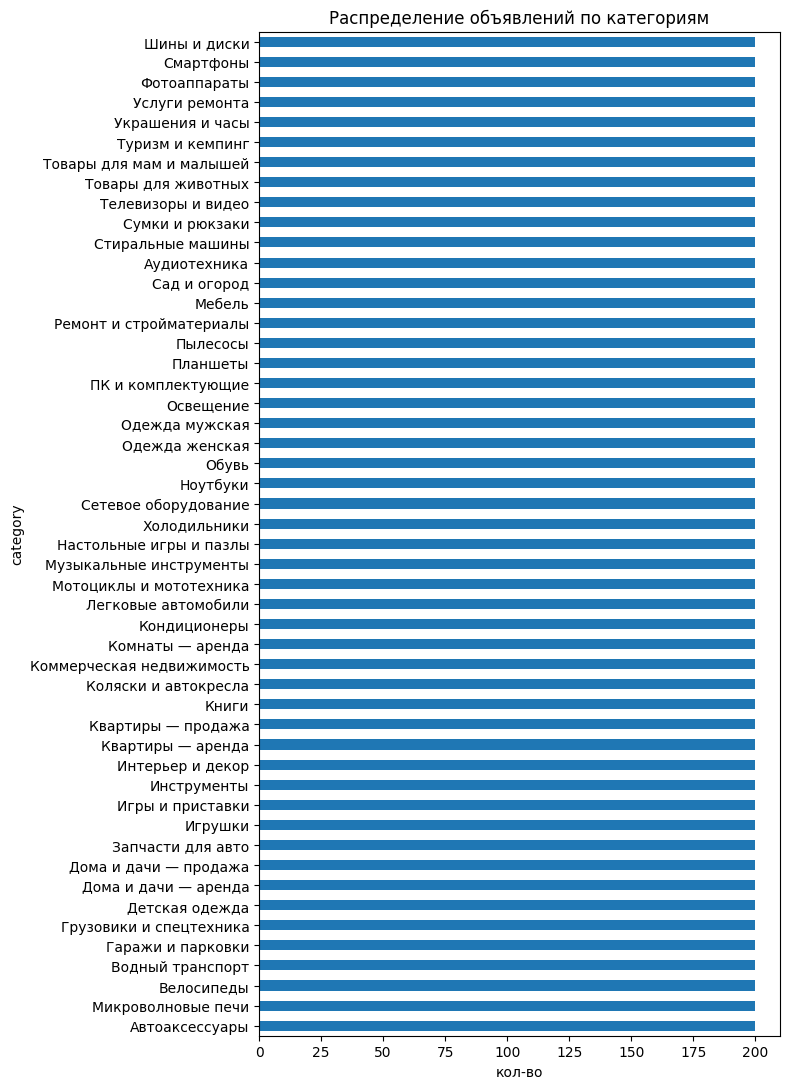

In [5]:
# Распределение категорий
if "category" in df.columns:
    counts = df["category"].value_counts().sort_values(ascending=True)
    plt.figure(figsize=(8, max(6, 0.22 * len(counts))))
    counts.plot(kind="barh")
    plt.title("Распределение объявлений по категориям")
    plt.xlabel("кол-во")
    plt.tight_layout()
    plt.show()


count    1.000000e+04
mean     1.224767e+06
std      5.028567e+06
min      9.700000e+02
5%       1.434860e+04
50%      1.441560e+05
95%      4.924022e+06
max      5.412417e+07
Name: price, dtype: float64


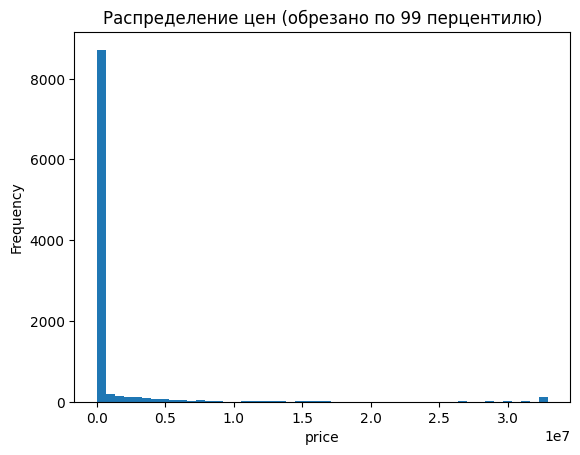

In [6]:
# Распределение цен
if "price" in df.columns:
    print(df["price"].describe(percentiles=[0.05,0.5,0.95]))
    plt.figure()
    df["price"].dropna().clip(upper=df["price"].quantile(0.99)).plot(kind="hist", bins=50)
    plt.title("Распределение цен (обрезано по 99 перцентилю)")
    plt.xlabel("price")
    plt.show()


In [7]:
# Длины title/description
for col in ["title", "description"]:
    lens = df[col].fillna("").str.len()
    print(f"{col}: mean={lens.mean():.1f}, max={lens.max()}, 99%={lens.quantile(0.99)}")


title: mean=36.0, max=70, 99%=61.0
description: mean=90.6, max=171, 99%=145.0


In [8]:
import re
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    return s.strip()

df["text"] = (df["title"].fillna("") + " " + df["description"].fillna("")).map(normalize_text)
df[["title","description","text"]].head(3)


,title,description,text
0,Продаю автоаксессуары — Санкт-Петербург,Покажу сегодня. Без дтп. Документы в наличии. Возможен торг. Состояние отличное. Город: Тюмень.,продаю автоаксессуары санкт петербург покажу сегодня без дтп документы в наличии возможен торг состояние отличное город тюмень
1,Продаю автоаксессуары — Казань,Город: Воронеж. Договорная. Обслуживание у дилера. Без посредников. Звоните / пишите. Доставка по городу. Бережная эксплуатация.,продаю автоаксессуары казань город воронеж договорная обслуживание у дилера без посредников звоните пишите доставка по городу бережная эксплуатация
2,В продаже автоаксессуары — Нижний Новгород,Гаражное хранение. Город: Новосибирск. Покажу сегодня. Разумный торг.,в продаже автоаксессуары нижний новгород гаражное хранение город новосибирск покажу сегодня разумный торг


In [9]:
# Количество объявлений по категориям
df["category"].value_counts()
print("Всего категорий:", df["category"].nunique())


Всего категорий: 50


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')

# Общие метрики
total_records = df.shape[0]
unique_categories = df['category'].nunique()
missing_title_desc = df[['title', 'description']].isnull().mean() * 100  # % пропусков
duplicates_before = len(df) - len(df.drop_duplicates())
duplicates_after = 0

print(f"Общие метрики:\n- Записи: {total_records}\n- Уникальные категории: {unique_categories}\n- Пропуски (%): {missing_title_desc}")


Общие метрики:
- Записи: 10000
- Уникальные категории: 50
- Пропуски (%): title          0.0
description    0.0
dtype: float64


[nltk_data] Downloading package punkt to /Users/maxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Статистика текстов:
        text_length_chars  text_length_words
count       10000.000000       10000.000000
mean          126.529000          16.153100
std            24.164096           3.393171
min            41.000000           5.000000
25%           110.000000          14.000000
50%           127.000000          16.000000
75%           143.000000          18.000000
max           206.000000          29.000000
Процент длинных текстов (>512 слов): 0.00%


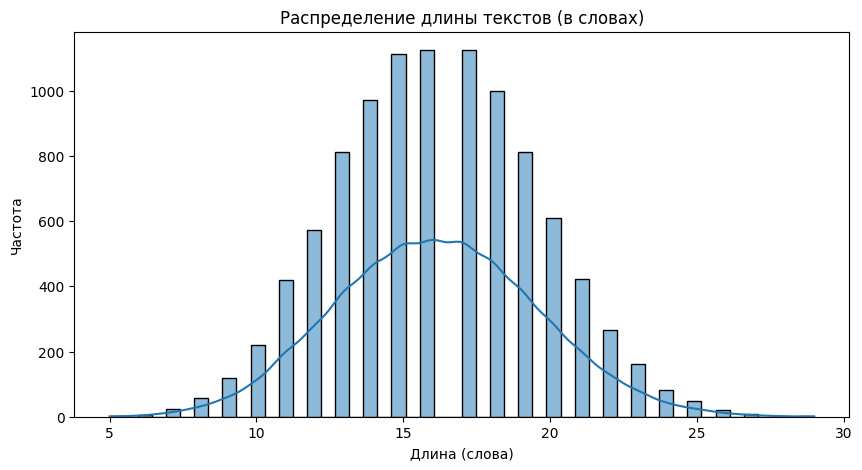

In [18]:

# Статистика текстов длина в символах и словах
df['text_length_chars'] = df['text'].str.len()
df['text_length_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))  # Слова

text_stats = df[['text_length_chars', 'text_length_words']].describe()
long_texts_pct = (df['text_length_words'] > 512).mean() * 100

print("\nСтатистика текстов:\n", text_stats)
print(f"Процент длинных текстов (>512 слов): {long_texts_pct:.2f}%")

# График распределения длин
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title('Распределение длины текстов (в словах)')
plt.xlabel('Длина (слова)')
plt.ylabel('Частота')
plt.show()


In [15]:

# Дополнительные топ-слова для выявления перекрытий
from collections import Counter
all_text = ' '.join(df['text'])
top_words = Counter(word_tokenize(all_text)).most_common(20)
print("\nТоп-20 слов (для выявления перекрытий/шума):\n", top_words)



Топ-20 слов (для выявления перекрытий/шума):
 [('город', 9512), ('и', 5898), ('в', 5060), ('торг', 4551), ('состояние', 3889), ('доставка', 3510), ('возможен', 2981), ('наличии', 2834), ('без', 2767), ('показ', 2719), ('самовывоз', 2272), ('на', 1974), ('чисто', 1962), ('бережная', 1933), ('эксплуатация', 1933), ('хорошее', 1929), ('аккуратно', 1907), ('после', 1864), ('обслуживания', 1864), ('отличное', 1854)]


## Итоги (01 · Data & EDA)

- Данные очищены, дубликаты сняты.
    
- Сплиты сформированы **без утечек** (группировка по идентификаторам).
    
- Отмечены риск-зоны: длинные тексты и классы-"близнецы".
    
- Готова база для бейслайна и трансформеров.
    

**Дальше:**  
(1) зафиксировать версию сплитов (seed/дата), (2) оставить небольшой sanity-набор вручную проверенных примеров, (3) завести чек-лист "data drift" для будущего продакшна.